In [1]:
import os
import tempfile
from typing import Dict, Optional

import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
from torch import Tensor
from torch.utils.data import DataLoader

from torchgeo.datasets import EuroSAT
from torchgeo.datamodules import EuroSATDataModule
from torchgeo.transforms import AugmentationSequential, indices
from torchgeo.trainers import ClassificationTask
from torchgeo.models import ResNet18_Weights

from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch import Trainer, seed_everything

wandb_logger = WandbLogger(project="eurosat3")
seed_everything(543)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: robmarkcole. Use `wandb login --relogin` to force relogin


Global seed set to 543


543

Setup the datamodule - validate train_dataset

In [2]:
batch_size = 64
num_workers = 8

datamodule = EuroSATDataModule(batch_size=batch_size, root="data", num_workers=num_workers)
datamodule.prepare_data()
datamodule.setup('fit')

In [3]:
len(datamodule.train_dataset)

16200

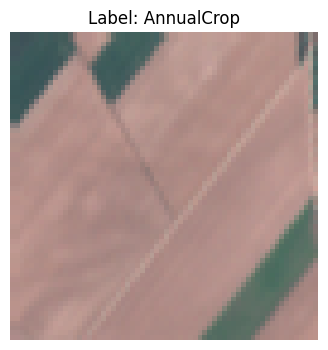

In [4]:
sample = datamodule.train_dataset[2]
fig = datamodule.train_dataset.plot(sample)

Experiment with the model and pretrained weights -> https://torchgeo.readthedocs.io/en/stable/tutorials/pretrained_weights.html

In [5]:
task = ClassificationTask(
    model="resnet18",
    # weights=True, # standard Imagenet
    weights=ResNet18_Weights.SENTINEL2_ALL_MOCO,
    num_classes=10,
    in_channels=13,
    loss="ce", 
    patience=10
)

In [6]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    # dirpath=experiment_dir,
    save_top_k=1,
    save_last=True,
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
)

trainer = Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    accelerator="cuda",
    logger=wandb_logger,
    # default_root_dir=experiment_dir,
    min_epochs=25,
    max_epochs=50,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model=task, datamodule=datamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | ResNet           | 11.2 M
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.852    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=25` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [8]:
trainer.test(model=task, datamodule=datamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_AverageAccuracy    │    0.9606452584266663     │
│       test_F1Score        │    0.9627777934074402     │
│     test_JaccardIndex     │    0.9261332750320435     │
│   test_OverallAccuracy    │    0.9627777934074402     │
│         test_loss         │    0.14018668234348297    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.14018668234348297,
  'test_AverageAccuracy': 0.9606452584266663,
  'test_F1Score': 0.9627777934074402,
  'test_JaccardIndex': 0.9261332750320435,
  'test_OverallAccuracy': 0.9627777934074402}]